In [1]:
using Distributions
using Random
using Plots
include("./polya.jl")
using .Polya

In [2]:
X = [2 10; 1 10]
println(Polya.mle(DirichletMultinomial, X))
println(Polya.gmm(DirichletMultinomial, X))

DirichletMultinomial{Float64}(n=20, α=[276.2222163331351, 252.6320408970934])
DirichletMultinomial{Float64}(n=20, α=[40.800000000000274, 37.400000000000254])


In [3]:
function draw_dirichlet_multinomial(n::Integer, α::Vector{T1}, T::Real, K::Integer) where {T1 <: Real}
    cdf = DirichletMultinomial(n, T .* α ./ sum(α))
    return rand(cdf, K)
end

draw_dirichlet_multinomial (generic function with 1 method)

In [4]:
K = 10
p = ones(K) ./ K
T = 0.5
Xk = draw_dirichlet_multinomial(100, p, T, 10000)

10×10000 Array{Int64,2}:
  0  94   0   0   2  16   0   1   0  …   0  98  33  34   0   0   2   0    0
  0   0  99   0   0   0   0   0   0      0   0   0  38   0   0  49  11    0
  0   0   0   0   0   0   1   0   0      2   0   0   0   4   0  49   0    0
  0   0   0   0  97  10   0   0   0      0   0  67   0   2   0   0   0    0
  3   5   0  18   0   0   0   0   2      0   2   0   0  91   0   0  61    0
  0   1   0  82   0  52   0   0   0  …   0   0   0   0   3  98   0   0    0
 93   0   0   0   1   0   3   0   0      0   0   0   0   0   2   0  23  100
  4   0   0   0   0  22   0   0  98     97   0   0   0   0   0   0   0    0
  0   0   0   0   0   0  76  99   0      0   0   0   0   0   0   0   0    0
  0   0   1   0   0   0  20   0   0      1   0   0  28   0   0   0   5    0

In [5]:
Polya.mle(DirichletMultinomial, Xk)

DirichletMultinomial{Float64}(
n: 100
α: [0.050107093001118964, 0.05122853088080749, 0.05179882135312586, 0.04881208118003468, 0.04998580720130787, 0.05075853502761984, 0.05021365237945029, 0.05106548571841099, 0.04862938152857411, 0.05010689722843019]
)


In [6]:
function compute_KLD(share::Array{Float64,N}, p::Vector{Float64}) where {N}
    all(sum(share, dims=1) .≈ 1) || throw(ArgumentError("Shares have to sum to 1.")) 
    deviation = log.(share ./ p)
    # log(0) is fine because 0*log(0) = 0
    replace!(deviation, -Inf=>0)
    # convert to vector instead of 1xK array
    return sum(share .* deviation, dims=1)
end

compute_KLD (generic function with 1 method)

In [ ]:
KLD = compute_KLD(Xk ./ sum(Xk, dims=1), p)
histogram(KLD[:])

In [7]:
P = DirichletMultinomial(20, T*p)
pmf = Polya.simulate_ECDF(P, 
    x -> compute_KLD(x ./ sum(x, dims=1),
        p), digits=3)

DiscreteNonParametric{Float64,Float64,Array{Float64,1},Array{Float64,1}}(
support: [0.504, 0.527, 0.538, 0.567, 0.58, 0.593, 0.595, 0.598, 0.612, 0.616  …  1.692, 1.715, 1.74, 1.784, 1.802, 1.88, 1.908, 1.978, 2.104, 2.303]
p: [1.000010000100001e-5, 1.000010000100001e-5, 1.000010000100001e-5, 2.000020000200002e-5, 1.000010000100001e-5, 2.000020000200002e-5, 1.000010000100001e-5, 1.000010000100001e-5, 1.000010000100001e-5, 1.000010000100001e-5  …  0.027770277702777027, 0.002830028300283003, 0.03144031440314403, 0.025700257002570025, 0.03602036020360204, 0.04524045240452405, 0.023210232102321024, 0.06221062210622106, 0.11226112261122612, 0.23854238542385423]
)


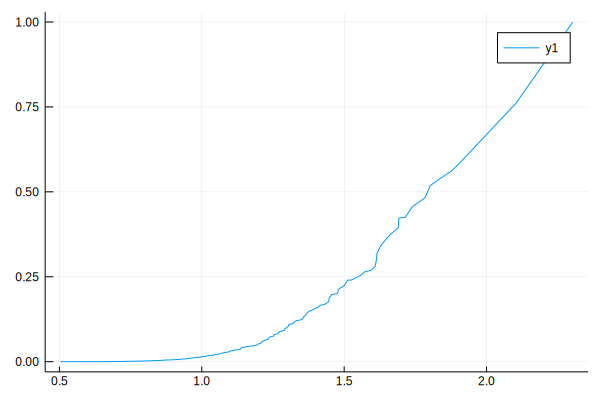

In [8]:
x = support(pmf)
p = cumsum(probs(pmf))
plot(x, p)

In [9]:
cdf(pmf, 2.2)

0.7614576145761457

In [10]:
mean(pmf)

1.8207186771867718

In [23]:
function compute_p_values(data)
    K, N = size(data)
    H0_params = Polya.mle(DirichletMultinomial, data, tol=1e-4)
    H0_shares = H0_params.α ./ sum(H0_params.α)
    actual_KLD = compute_KLD(data ./ sum(data, dims=1), H0_shares)
    
    p = zeros(Float64, N)
    for i = 1:N
        # actual number of shipments treated as a parameter
        H1 = DirichletMultinomial(sum(data[:,i]), H0_params.α)
        pmf = Polya.simulate_ECDF(H1, 
            x -> compute_KLD(x ./ sum(x, dims=1), 
                    H0_params.α ./ H0_params.α0), 
            maxiter=1000, digits=2)
        p[i] = 1 - cdf(pmf, actual_KLD[1,i])
    end
    return p
end

compute_p_values (generic function with 1 method)

In [12]:
compute_p_values(Xk)

([0.33633633633633675, 0.2862862862862866, 0.14814814814814836, 0.47947947947947955, 0.2142142142142145, 0.953953953953954, 0.5995995995995995, 0.10010010010010029, 0.17617617617617642, 0.9139139139139139  …  0.05305305305305341, 0.2402402402402406, 0.17617617617617642, 0.5505505505505506, 0.9339339339339339, 0.40740740740740744, 0.17317317317317327, 0.7217217217217218, 0.887887887887888, 0.0490490490490495], [1.7818118118118118, 1.7685285285285286, 1.762272272272272, 1.7889389389389387, 1.7842542542542543, 1.767947947947948, 1.7804804804804801, 1.7727527527527533, 1.7637137137137135, 1.7895095095095095  …  1.7854554554554554, 1.7665765765765766, 1.7906106106106099, 1.7592392392392393, 1.805935935935936, 1.7721821821821824, 1.7694994994994995, 1.7577177177177181, 1.7731431431431433, 1.7901701701701698], [2.001763835195923, 2.0518330653362855, 2.227973957891386, 1.824286463879449, 2.177404615971631, 1.1009655501196554, 1.6464628649388853, 2.279465347090891, 2.189321130365325, 1.27013397

In [31]:
using CSVFiles
data = load("../temp/shipment-clean.csv")
"So as not to make notebook big."

"So as not to make notebook big."

In [16]:
function get_destination_matrix(data; country::String, year::Int = 2017)
    cut = 3
    output = zeros(Int, (97, 0))
    for row in collect(data)
        fields = keys(row)[cut+1:end]
        if row.iso2_d == country && row.year == year
            output = [output zeros(Int, (length(fields), 1))]
            for (i, field) in enumerate(fields)
                output[i,end] = row[field]
            end
        end
    end
    return output
end

get_destination_matrix (generic function with 1 method)

In [34]:
countries = ["RU", "US"]
ps = zeros(Float64, length(countries), 28)
for (i, country) in enumerate(countries) 
    segment = get_destination_matrix(data, country=country, year=2017)
    ps[i,:] = compute_p_values(segment[1:end-1,:])
end


In [35]:
ps

2×28 Array{Float64,2}:
 0.022022  0.0       0.167167  0.0       …  0.977978  0.001001  0.174174
 0.479479  0.004004  0.487487  0.317317     0.716717  0.132132  0.0